In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import datetime as dt
import pickle

from utils import processing
from utils import utils

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import wandb
from wandb.keras import WandbCallback


In [2]:
def metrics(true, pred):
    print(f'MSE: {np.mean(mean_squared_error(true, pred))}')
    print(f'RMSE: {np.sqrt(np.mean(mean_squared_error(true, pred)))}')
    print(f'MAE: {np.mean(mean_absolute_error(true, pred))}')
    print(f'MAPE: {np.mean(mean_absolute_percentage_error(true, pred))}')

In [3]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [4]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [5]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]

In [6]:
# Processing Parameters
steps = 1 # timesteps: 1 hour
num_features = 9

lookback = 744 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 224
epochs = 50
lr = 0.04

In [7]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.ts_offset_split(kld, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.ts_offset_split(stb, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [8]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (224, 744, 9)
Target Shape: (224, 1)


# GRU: Kolding Dataset

In [9]:
# GRU Benchmark
GRU_base_kld = Sequential()
GRU_base_kld.add(Input(shape=(lookback, num_features)))

GRU_base_kld.add(GRU(96, return_sequences=False, activation='tanh'))
GRU_base_kld.add(Dropout(0.2))

GRU_base_kld.add(Dense(1))

GRU_base_kld.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

GRU_base_kld.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 96)                30816     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 30,913
Trainable params: 30,913
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Callbacks
estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, verbose=1)

ckpt_path = "../model/models/GRU_benchmark_kld.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


In [11]:
history_kld = GRU_base_kld.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Epoch 1/50
66/66 [==============================] - 240s 4s/step - loss: 0.5583 - mae: 0.5583 - val_loss: 0.4038 - val_mae: 0.4706

Epoch 00001: val_loss improved from inf to 0.40380, saving model to ../model/models\GRU_benchmark_kld.h5
Epoch 2/50
66/66 [==============================] - 178s 3s/step - loss: 0.3666 - mae: 0.4378 - val_loss: 0.3911 - val_mae: 0.4386

Epoch 00002: val_loss improved from 0.40380 to 0.39109, saving model to ../model/models\GRU_benchmark_kld.h5
Epoch 3/50
66/66 [==============================] - 194s 3s/step - loss: 0.3487 - mae: 0.4243 - val_loss: 0.3792 - val_mae: 0.4240

Epoch 00003: val_loss improved from 0.39109 to 0.37918, saving model to ../model/models\GRU_benchmark_kld.h5
Epoch 4/50
66/66 [==============================] - 202s 3s/step - loss: 0.3434 - mae: 0.4207 - val_loss: 0.3532 - val_mae: 0.4216

Epoch 00004: val_loss improved from 0.37918 to 0.35315, saving model to ../model/models\GRU_benchmark_kld.h5
Epoch 5/50
66/66 [======================

66/66 [==============================] - 247s 4s/step - loss: 0.0784 - mae: 0.2130 - val_loss: 0.0916 - val_mae: 0.2263

Epoch 00039: val_loss did not improve from 0.08715
Epoch 40/50
66/66 [==============================] - 244s 4s/step - loss: 0.0767 - mae: 0.2098 - val_loss: 0.1015 - val_mae: 0.2412

Epoch 00040: val_loss did not improve from 0.08715
Epoch 41/50
66/66 [==============================] - 243s 4s/step - loss: 0.0787 - mae: 0.2145 - val_loss: 0.0919 - val_mae: 0.2310

Epoch 00041: val_loss did not improve from 0.08715
Epoch 42/50
66/66 [==============================] - 259s 4s/step - loss: 0.0778 - mae: 0.2115 - val_loss: 0.0922 - val_mae: 0.2283

Epoch 00042: val_loss did not improve from 0.08715
Epoch 43/50
66/66 [==============================] - 274s 4s/step - loss: 0.0768 - mae: 0.2113 - val_loss: 0.0868 - val_mae: 0.2225

Epoch 00043: val_loss improved from 0.08715 to 0.08685, saving model to ../model/models\GRU_benchmark_kld.h5
Epoch 44/50
66/66 [===============

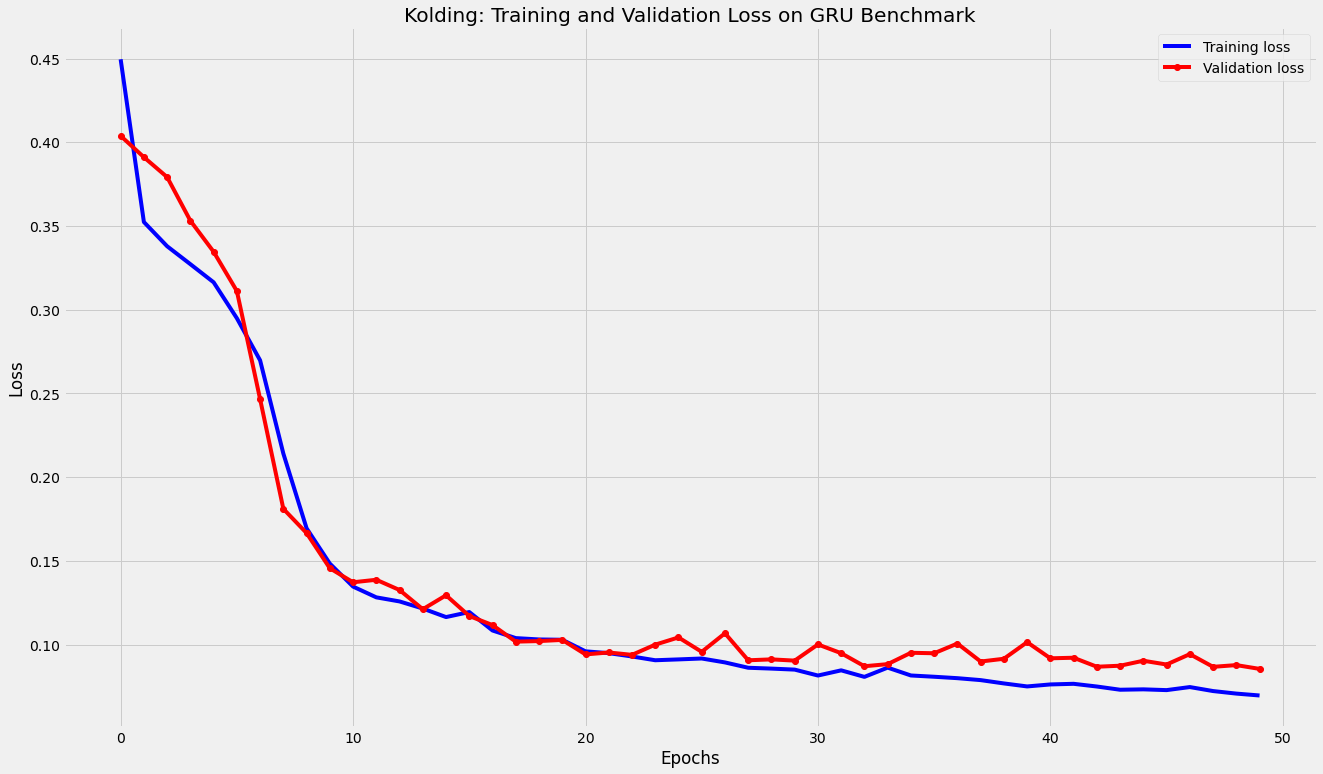

In [12]:
utils.plot_training(history_kld, "Kolding: Training and Validation Loss on GRU Benchmark")

In [12]:
kld_eval = GRU_base_kld.evaluate(kld_test)

12/12 [==============================] - 1s 93ms/step - loss: 0.1302 - mae: 0.2675


In [22]:
kld_std = 31.31291841
kld_mean = 87.50684772
print(f'Inverse Scaled MAE: {round(kld_eval[1] * kld_std, 2)}')

Inverse Scaled MAE: 8.38


In [20]:
kld_pred = GRU_base_kld.predict(kld_test)
inv_kld_pred = (kld_pred * kld_std ) + kld_mean
y_true = pd.read_csv('y_true_kolding.csv', index_col='Datetime', parse_dates=['Datetime'])

MSE: 133.40220642089844  
MAE: 8.549830436706543  
MAPE: 8.171585083007812  


In [3]:
np.sqrt(133.40220642089844)

11.549987290940992

In [30]:
metrics(y_true, inv_kld_pred)

InvalidArgumentError: Incompatible shapes: [2640,1] vs. [1488,1] [Op:SquaredDifference]

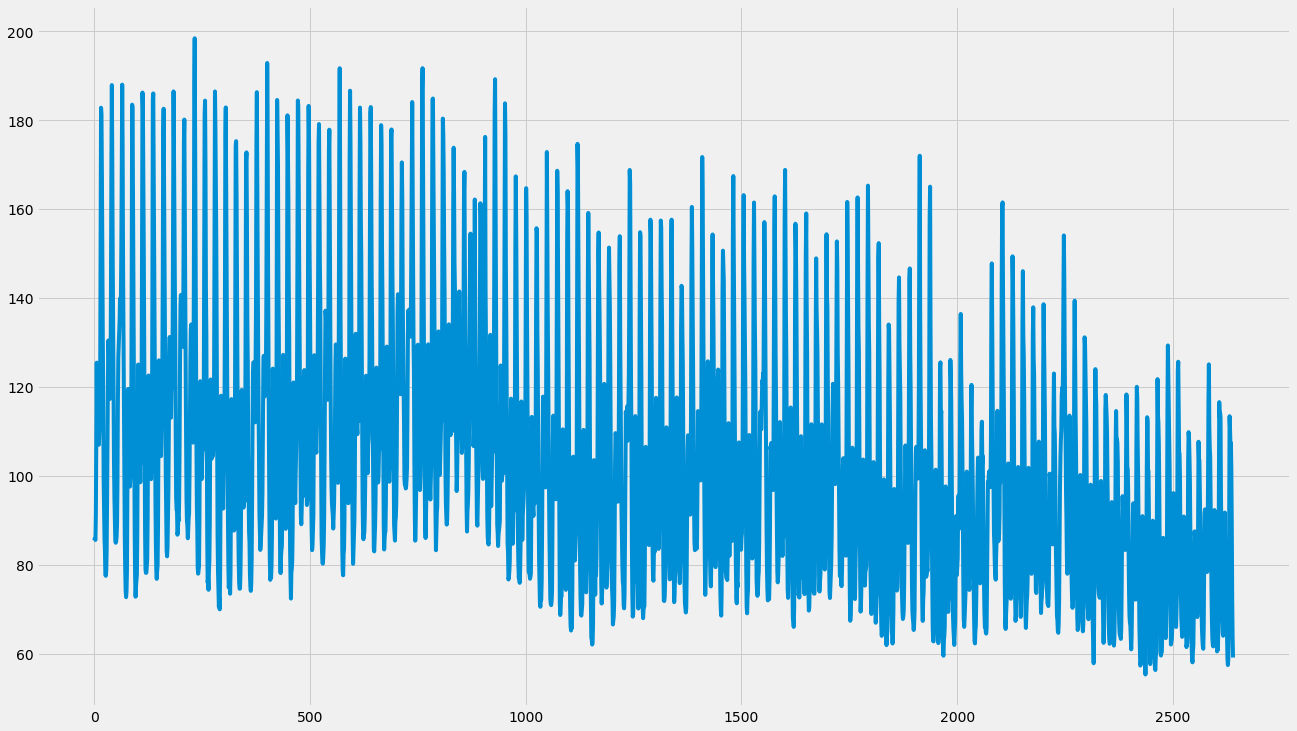

In [25]:
plt.plot(inv_kld_pred)

# GRU: Middelfart Dataset

In [13]:
# GRU Benchmark
GRU_base_stb = Sequential()
GRU_base_stb.add(Input(shape=(lookback, num_features)))

GRU_base_stb.add(GRU(96, return_sequences=False, activation='tanh'))
GRU_base_stb.add(Dropout(0.2))

GRU_base_stb.add(Dense(1))

GRU_base_stb.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

GRU_base_stb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 96)                30816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 30,913
Trainable params: 30,913
Non-trainable params: 0
_________________________________________________________________


In [14]:
estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "../model/models/GRU_benchmark_stb.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


In [15]:
history_stb = GRU_base_stb.fit(
    stb_train,
    epochs=epochs,
    validation_data=stb_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Epoch 1/50
66/66 [==============================] - 248s 4s/step - loss: 0.6056 - mae: 0.5905 - val_loss: 0.4236 - val_mae: 0.4505

Epoch 00001: val_loss improved from inf to 0.42362, saving model to ../model/models\GRU_benchmark_stb.h5
Epoch 2/50
66/66 [==============================] - 240s 4s/step - loss: 0.3639 - mae: 0.4390 - val_loss: 0.3906 - val_mae: 0.4295

Epoch 00002: val_loss improved from 0.42362 to 0.39060, saving model to ../model/models\GRU_benchmark_stb.h5
Epoch 3/50
66/66 [==============================] - 239s 4s/step - loss: 0.3457 - mae: 0.4270 - val_loss: 0.3760 - val_mae: 0.4341

Epoch 00003: val_loss improved from 0.39060 to 0.37600, saving model to ../model/models\GRU_benchmark_stb.h5
Epoch 4/50
66/66 [==============================] - 236s 4s/step - loss: 0.3355 - mae: 0.4227 - val_loss: 0.3665 - val_mae: 0.4197

Epoch 00004: val_loss improved from 0.37600 to 0.36647, saving model to ../model/models\GRU_benchmark_stb.h5
Epoch 5/50
66/66 [======================

KeyboardInterrupt: 

In [ ]:
utils.plot_training(history_stb, "Middelfart: Training and Validation Loss on GRU Benchmark")

In [18]:
stb_eval = GRU_base_stb.evaluate(stb_test)

12/12 [==============================] - 1s 95ms/step - loss: 0.1099 - mae: 0.2489


In [19]:
stb_std = 18.33954707
print(f'Inverse Scaled MAE: {round(stb_eval[1] * stb_std, 2)}')

Inverse Scaled MAE: 4.56
